# 获取数据

In [43]:
import sys
sys.path.append('../../Utils')

import os 
from data_feed import DataFeed
datafeed = DataFeed(config_path=os.path.join('..', 'config.ini'),
                    local_data_dir='../data')

## 上证综指

### 加载下载好的Joinquant数据（2005之后）

In [44]:
""" 读取本地数据 """
daily_001 = datafeed.load_local_data('000001.XSHG', 'daily')
daily_001.head()

数据加载完成~ 
first_dt:2005-01-04 23:59:59, 
last_dt:2022-01-28 23:59:59


,open,close,high,low,volume,money,date,time
0,1260.78,1242.77,1260.78,1238.18,816177000.0,4.418452e+09,2005-01-04,23:59:59
1,1241.68,1251.94,1258.58,1235.75,867865100.0,4.916589e+09,2005-01-05,23:59:59
2,1252.49,1239.43,1252.73,1234.24,792225400.0,4.381370e+09,2005-01-06,23:59:59
3,1239.32,1244.75,1256.31,1235.51,894087100.0,5.040042e+09,2005-01-07,23:59:59
4,1243.58,1252.40,1252.72,1236.09,723468300.0,4.118292e+09,2005-01-10,23:59:59


### 从tushare下载数据（2005之前）

In [45]:
import  configparser
config = configparser.ConfigParser()
config.read('../config.ini')
token = config.get('tushare', 'token')

import tushare as ts
ts.set_token(token)

In [46]:
pro = ts.pro_api()
daily_001_1995_2005 = pro.index_daily(ts_code='000001.SH', start_date='19950101', end_date='20041231')
daily_001_1995_2005 = daily_001_1995_2005.sort_values('trade_date')
daily_001_1995_2005.head()

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount
2425,000001.SH,19950103,639.88,637.72,647.71,630.53,647.87,-7.99,-1.2333,234518.0,180693.264
2424,000001.SH,19950104,653.81,641.90,655.51,638.86,639.88,13.93,2.1770,422220.0,306923.352
2423,000001.SH,19950105,646.89,656.20,657.45,645.81,653.81,-6.92,-1.0584,430123.0,301532.788
2422,000001.SH,19950106,640.76,642.75,643.89,636.33,646.89,-6.13,-0.9476,487482.0,353757.725
2421,000001.SH,19950109,625.97,637.52,637.55,625.04,640.76,-14.79,-2.3082,509851.0,398519.515


In [47]:
daily_001_1995_2005 = daily_001_1995_2005[['trade_date', 'close']].rename(columns={'trade_date': 'date'})
daily_001_1995_2005['date'] = daily_001_1995_2005['date'].apply(lambda x: '{}-{}-{}'.format(x[:4], x[4:6], x[6:8]))
daily_001_1995_2005

,date,close
2425,1995-01-03,639.880
2424,1995-01-04,653.810
2423,1995-01-05,646.890
2422,1995-01-06,640.760
2421,1995-01-09,625.970
...,...,...
4,2004-12-27,1280.272
3,2004-12-28,1278.943
2,2004-12-29,1274.313
1,2004-12-30,1273.709


### 合并2005前后数据，用于作为corpus_update_data

In [48]:
import pandas as pd

all_001 = pd.concat([daily_001_1995_2005, daily_001]).reset_index(drop=True)
all_001

,date,close,open,high,low,volume,money,time
0,1995-01-03,639.88,NaN,NaN,NaN,NaN,NaN,NaN
1,1995-01-04,653.81,NaN,NaN,NaN,NaN,NaN,NaN
2,1995-01-05,646.89,NaN,NaN,NaN,NaN,NaN,NaN
3,1995-01-06,640.76,NaN,NaN,NaN,NaN,NaN,NaN
4,1995-01-09,625.97,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
6572,2022-01-24,3524.11,3508.24,3531.61,3500.14,2.802683e+10,3.580097e+11,23:59:59
6573,2022-01-25,3433.06,3509.28,3519.83,3433.06,3.273538e+10,3.837277e+11,23:59:59
6574,2022-01-26,3455.67,3442.69,3462.12,3417.76,2.751228e+10,3.383124e+11,23:59:59
6575,2022-01-27,3394.25,3456.10,3456.36,3392.02,2.806065e+10,3.465340e+11,23:59:59


# 定义函数
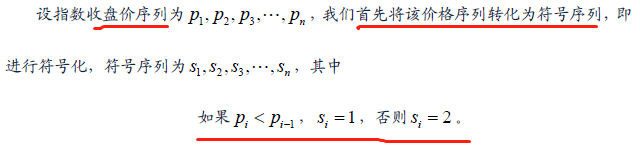

In [49]:
from tqdm import tqdm
import itertools
import pandas as pd

## 初始化语料库

In [50]:
class MyCorpus():
    def __init__(self):
        """
            freq_dict: {
                1: {'1': X, '2': X}
                2: {'11': X, '12': X, '21': X, 22: X}
                ...
                N: {...}
            }
            p_df_dict: {
                1:  DataFrame -> [符号数，样本数，频度]
                2:
                ...
                N: 
            }
        """        
        self.freq_dict = {}
        self.p_df_dict = {}
        
    def load_data(self, p_series, N=2, is_renew=False):
        """ 根据N, 用p_series更新相应level的 freq_dict 和 p_df_dict
            注：N最大为len(p_series)-1，因为两个p确定一个s
        """
        # 生成 str_s_series
        str_s_series = self._generate_str_s_series(p_series)
        
        # 如果没有对应的key=N/is_renew=True，就对freq_dict和p_df_dict进行初始化
        if N not in self.freq_dict or is_renew:
            Ngram_items = [''.join(list(map(lambda x:str(x), i))) for i in itertools.product([1,2], repeat=N)]
            self.freq_dict[N] = {item: 0 for item in Ngram_items}
            self.p_df_dict[N] = None

        # Update s_series into freq_dict 
        for i in range(len(str_s_series)-N+1):
            tmp_s = str_s_series[i: i+N]
            self.freq_dict[N][tmp_s] += 1
        
        # generate p_df from freq_dict
        p_df = self._generate_p_df(self.freq_dict[N])
        self.p_df_dict[N] = p_df
    
    def predict_prob(self, p_series):
        """ 输入p_series，MyCorpus返回目前N（ N=len(p_series) ）阶模型下的全部可能结果及对应概率 """
        N = len(p_series)
        if N not in self.p_df_dict:
            print('没有找到{}阶模型的统计结果用于预测'.format(N))
            return 
        str_s_series = self._generate_str_s_series(p_series) # 长度为N-1的str_s_series
        # 从历史库中匹配得到结果
        p_df = self.p_df_dict[N]
        pred_df = p_df[p_df['符号数'].apply(lambda x: x[:N-1]==str_s_series)].copy()
        pred_df = pred_df.sort_values('样本数', ascending=False)
        return pred_df        
    
    def predict(self, p_series):
        """ 输入p_series，MyCorpus返回目前N（ N=len(p_series) ）阶模型下的最优结果 """
        pred_df = self.predict_prob(p_series)
        best_symb = pred_df['符号数'].values[0][-1]
        return best_symb
    
    @staticmethod
    def _generate_str_s_series(p_series):
        """ 1->下跌 2->不下跌 """
        p_diff_series = (p_series - p_series.shift(1)).dropna()
        s_series = 2 - 1 * (p_diff_series<0)
        return ''.join(s_series.astype(str))
    
    def _generate_p_df(self, freq_dict):
        """ 从freq_dict生成p_df """
        p_df = pd.DataFrame([[k,v] for k,v in freq_dict.items()])
        p_df.columns = ['符号数', '样本数']
        p_df['频度'] = p_df['样本数']/p_df['样本数'].sum()
        return p_df

### 使用样例

In [51]:
my_corpus = MyCorpus()

""" 生成3-10阶corpus """
#my_corpus.load_data(daily_001_1995_2005['close'], 3)
#my_corpus.load_data(daily_001_1995_2005['close'], 4)
#my_corpus.load_data(daily_001_1995_2005['close'], 5)
my_corpus.load_data(daily_001_1995_2005['close'], 6)
#my_corpus.load_data(daily_001_1995_2005['close'], 7)
#my_corpus.load_data(daily_001_1995_2005['close'], 8)
#my_corpus.load_data(daily_001_1995_2005['close'], 9)
#my_corpus.load_data(daily_001_1995_2005['close'], 10)

In [52]:
""" 6阶下的p_df_dict """
my_corpus.p_df_dict[6]#[my_corpus.p_df_dict[6]['符号数'].apply(lambda x:x[:5]=='21111')]

,符号数,样本数,频度
0,111111,32,0.013223
1,111112,37,0.015289
2,111121,43,0.017769
3,111122,38,0.015702
4,111211,38,0.015702
...,...,...,...
59,222122,43,0.017769
60,222211,36,0.014876
61,222212,45,0.018595
62,222221,35,0.014463


In [53]:
my_corpus.predict(all_001['close'][:6])

'2'

## 计算每日信号和止损价格

In [54]:
def calc_signal_and_sl_price(mkt_data, corpus, N, corpus_update_data, sl_perc=0.01):
    """  
        mkt_data:           用来标记signal的交易标的数据
        corpus_dict:        初始化的corpus_dict，应已完成N阶，到first_day(mkt_data)-1日的初始化工作                            
        N:                  应用的N-gram模型的阶数，copus_dict应已完成对应阶数的初始化
        corpus_update_data: 用于不断更新corpus_dict的基础数据，必须确保其满足以下条件：
                            - 最早日期要<=：first_day(mkt_data)-N
                            - 最晚日期要>=：last_day(mkt_data)
    """
    
    """ 截取corpus_update_data [first_day(mkt_data)-N+1~last_day(mkt_data)] """
    first_d_mkt_data = mkt_data['date'].values[0]
    last_d_mkt_data  = mkt_data['date'].values[-1]
    match_first_d_idx = corpus_update_data[corpus_update_data['date']==first_d_mkt_data].index[0]
    match_last_d_idx  = corpus_update_data[corpus_update_data['date']==last_d_mkt_data].index[0]
    
    corpus_update_data = corpus_update_data[match_first_d_idx-N: match_last_d_idx+1]
    corpus_update_p_series = corpus_update_data['close']
    
    """ 循环计算signal & 更新Corpus """
    signals = []
    sl_prices = [np.nan]
    pre_sig = None  # 用于计算sl_price
    for i, o in enumerate(tqdm(mkt_data['open'])):
        tmp_p_series = corpus_update_p_series[i: i+N+1] # 长度为N+1的p_series（即长度为N的s_series）
        
        # 过去N+1期p_series(即过去N期s_series)，用来更新Corpus
        corpus.load_data(tmp_p_series, N=N) 
        
        # 过去N期p_series(即过去N-1期s_series)，用来预测当期best_sig（即下期走势）
        pred_p_series = tmp_p_series[1:]
        pred_symb = corpus.predict(pred_p_series)
        sig = 1 if pred_symb=='2' else -1
        
        signals.append(sig)
        
        # 根据pre_sig决定当期sl_price
        if pre_sig:
            sl_price = o * (1 + sl_perc*(pre_sig<0) - sl_perc*(pre_sig>0))
            sl_prices.append(sl_price)

        pre_sig = sig        
        
    """ 赋值 """
    mkt_data['signal'] = signals
    mkt_data['sl_price'] = sl_prices
    return mkt_data

## 计算持仓

In [55]:
def calc_position(mkt_data, shift_period=1, otime_limit=None, etime_limit=None, 
                  is_consider_open=True, is_consider_sl=False, is_daily_close=False,
                  comm = None, leverage=None):
    """  
        params:
            1. shift_period:     偏移周期：
                                    接收到信号后，在T+shift_period期才按信号进行操作。
                                    一般为1，若为0则代表用了未来数据
            2. otime_limit:      最早持仓时间：
                                    针对日内策略。若有值，则会将每天otime_limit及之前的仓位强制设为0
            3. etime_limit:      最晚持仓时间：
                                    针对日内策略。若有值，则会将
            4. is_consider_open: 是否考虑持仓信号到下周期开盘才能操作：
                                    若是，则会将【开仓第一期的hold_in_price & 平仓最后一期的hold_out_price】设为下周期开盘价
            5. is_consider_sl:   是否考虑止损：
                                    需要mkt_data有【sl_price】列
            6. is_daily_close:   是否每日关仓：
                                    若是，则每天第一个周期的hold_in_price=open，每天最后一个周期hold_out_price=close
            7. comm:             是否考虑双边佣金：
                                    若为None则不考虑，若为数值则为佣金率，如0.0002代表双边万二手续费率
            8. leverage:         是否考虑杠杆： 
                                    若为None或1则代表不考虑杠杆，若大于1则代表考虑leverage倍的杠杆
    
        利用已经算好的signal, sl_price两列数据及对应参数，计算出以下信息：
            1. is_sl：               是否止损
            2. position：            持仓头寸（在-1到1之间）
            3. hold_in_price：       当周期持仓入成本
            4. hold_out_price：      当周期持仓出成本
            5. open_pos_comm_perc ： 当周期折损买入手续费后比例
            6. close_pos_comm_perc： 当周期折损卖出手续费后比例

        每周期的hold_r公式应为:
            hold_r =  (hold_out_price/hold_in_price) * open_pos_comm_perc * close_pos_comm_perc -1      
    """
    signal = mkt_data['signal']
    position = signal.fillna(method='ffill').shift(shift_period).fillna(0)
    sl_price = mkt_data['sl_price']

    """ A. 是否考虑止损，会根据止损结果重新过滤一遍signal，进而确定position列 """
    if is_consider_sl:        
        """ 1. 计算is_sl：
                - 若持有空仓，sl-h<=0则止损了; 
                - 若持有多仓，l-sl<=0则止损了
        """
        is_sl = (  (-sl_price * np.sign(position))
                 - (mkt_data['high']*(position<0)) 
                 + (mkt_data['low']*(position>0)))<=0
        """ 2. 考虑止损结果生成position """
        #  将止损当期signal设为0（当期signal已为1 or -1，则不变）
        signal_consider_sl = signal.copy()
        signal_consider_sl[(signal_consider_sl.isnull()) & (is_sl)] = 0 
        position = signal_consider_sl.fillna(method='ffill').shift(shift_period).fillna(0)
        """ 3. 空仓期间的is_sl设为False """
        is_sl[position==0] = False
    else:
        is_sl = False
        
    """ B. 是否每天otime前空仓 """
    if otime_limit:
        position[mkt_data['time']<=otime_limit]=0
    
    """ C. 是否每天etime后空仓 """
    if etime_limit:
        position[mkt_data['time']>etime_limit]=0
    
    """ 生成hold_in_price, hold_out_price """
    # 1. 先初始化 period_out_price = close； period_in_price=close.shift(1)
    open_p, close = mkt_data['open'], mkt_data['close']
    hold_in_price =  close.shift(1).copy()
    hold_in_price[close.index[0]] = open_p.values[0]
    hold_out_price = close.copy()

    # 2. 若考虑持仓信号到第二天开盘才能操作
    if is_consider_open:
        # 2-1. 仓位变动第一期的period_in_price为当日open
        hold_in_price[abs(position - position.shift(1).fillna(0))>0] = open_p
        # 2-2. 仓位变动前最后一期的period_out_price为第二日open (除了整个序列最后一天不变)
        hold_out_price[abs(position - position.shift(-1).fillna(0))>0] = open_p.shift(-1)
        hold_out_price[hold_out_price.index[-1]] = close.values[-1]
    
    # 3. 若考虑止损 （mkt_data要先搭配calc_position()函数，计算得到is_sl列）
    if is_consider_sl:
        # 若当期止损了，hold_out_price设为止损价
        #（若多头，止损为open、sl_price里较低的； 若空头，止损为open、sl_price里较高的）
        hold_out_price[is_sl] = (position>0) * np.minimum(open_p, sl_price) + (position<0) * np.maximum(open_p, sl_price)
        #hold_out_price[is_sl] = (position>0) * np.where(open_p>sl_price, sl_price, open_p) + (position<0) * np.where(open_p>sl_price, open_p, sl_price)
        # 若上期止损了，当期hold_in_price设为开盘价
        sl_next_idxes = mkt_data[is_sl].index.values+1
        sl_next_idxes = sl_next_idxes[sl_next_idxes<=mkt_data.index.values[-1]]
        hold_in_price.loc[sl_next_idxes] = open_p
    
    # 4. 是否每日收盘前平仓
    if is_daily_close:
        daily_last_idxes = mkt_data.drop_duplicates(subset='date', keep='last').index
        hold_out_price.loc[daily_last_idxes.values] = close        
        daily_first_idxes = mkt_data.drop_duplicates(subset='date', keep='first').index
        hold_in_price.loc[daily_first_idxes.values] = open_p
        
    """ 考虑换仓手续费 """ 
    if comm:
        # 换仓后首期 
        if is_consider_sl: # （有止损：仓位相比上期有变动 或 上期止损，当期仓位不为0）
            is_open_pos = ( (abs(position-position.shift(1))>0)|(is_sl.shift(1)) ) * (abs(position)>0)
        else:              # （无止损：仓位相比上期有变动，            当期仓位不为0）
            is_open_pos = (abs(position-position.shift(1))>0) * (abs(position)>0)
        open_pos_comm_perc = 1/(1+comm * is_open_pos)
        # 换仓前末期
        if is_consider_sl: # （有止损：下期仓位有变动 或 当期止损，当期仓位不为0）
            is_close_pos = ( (abs(position-position.shift(-1))>0)|(is_sl) ) * (abs(position)>0)
        else:             # （无止损：下期仓位有变动             ，当期仓位不为0）
            is_close_pos = (abs(position-position.shift(-1))>0) * (abs(position)>0)
        close_pos_comm_perc = (1-comm * is_close_pos)  
    else:
        open_pos_comm_perc = 1.0
        close_pos_comm_perc = 1.0
    
    """ 考虑杠杆 """
    if leverage:
        position *= leverage
    
    """ 赋值 """
    mkt_data['position'] = position
    mkt_data['is_sl'] = is_sl
    mkt_data['hold_in_price'] = hold_in_price * abs(np.sign(position))
    mkt_data['hold_out_price'] = hold_out_price * abs(np.sign(position))
    mkt_data['open_pos_comm_perc'] = open_pos_comm_perc
    mkt_data['close_pos_comm_perc'] = close_pos_comm_perc
    return mkt_data

## 策略评估

### 统计

#### Old Defination

In [56]:
def statistic_performance(mkt_data, 
                          r0=0.03, 
                          data_period=1440,
                          is_consider_sl=False):
    """  
        mkt_data：        回测标的的DataFrame，需要已经计算好position列（若is_consider_sl=True，还需要计算好sl_price列）
        r0:               无风险标的年化收益，用于和data_perod一起计算超额收益和夏普率
        data_period：     mkt_data数据的频率，单位为分钟。如1440代表日频数据，1代表1分钟频率数据。
                          用于和r0一起计算超额收益、夏普率
        is_consider_sl:   是否考虑止损，若为True则统计指标中增加【多头止损率、空头止损率】
    """
    position = mkt_data['position']
    hold_in_price = mkt_data['hold_in_price']
    hold_out_price = mkt_data['hold_out_price']
    is_sl = mkt_data['is_sl']
    open_pos_comm_perc = mkt_data['open_pos_comm_perc']
    close_pos_comm_perc = mkt_data['close_pos_comm_perc']
    
    # 计算【回测数据首日】到【回测数据尾日】的长度（换算为年），用于后续计算年化收益、年化夏普等
    d_first = mkt_data['date'].values[0]
    d_last = mkt_data['date'].values[-1]
    d_period = datetime.datetime.strptime(d_last, '%Y-%m-%d') - datetime.datetime.strptime(d_first, '%Y-%m-%d')
    y_period = d_period.days / 365

    """      序列型特征 
        hold_in_price:  周期持仓入价格
        hold_out_price: 周期持仓出价格
        hold_r :        持仓收益
        hold_win :      持仓胜负
        hold_cumu_r :   累计持仓收益
        drawdown :      回撤
        ex_hold_r :     超额收益
    """
    
    """ 每期的持仓收益hold_r是计算的第一个序列，也是后续统计的核心 
        hold_r = hold_out_price/hold_in_price - 1
    """
    hold_r = position * (hold_out_price/hold_in_price-1)
    # 考虑换仓成本 
    hold_r = open_pos_comm_perc * close_pos_comm_perc * (1+hold_r) - 1
    hold_r.fillna(0.0, inplace=True)
    hold_win = hold_r>0
    hold_cumu_r = (1+hold_r).cumprod() - 1
    drawdown = (hold_cumu_r.cummax()-hold_cumu_r)/(1+hold_cumu_r).cummax()    
    ex_hold_r= hold_r-r0/(250*1440/data_period)
    
    mkt_data['hold_r'] = hold_r
    mkt_data['hold_win'] = hold_win
    mkt_data['hold_cumu_r'] = hold_cumu_r
    mkt_data['drawdown'] = drawdown
    mkt_data['ex_hold_r'] = ex_hold_r
    
    """       数值型特征 
        v_hold_cumu_r：         累计持仓收益
        v_pos_hold_times：      多仓开仓次数
        v_pos_hold_win_times：  多仓开仓盈利次数
        v_pos_hold_period：     多仓持有周期数
        v_pos_hold_win_period： 多仓持有盈利周期数
        v_neg_hold_times：      空仓开仓次数
        v_neg_hold_win_times：  空仓开仓盈利次数
        v_neg_hold_period：     空仓持有盈利周期数
        v_neg_hold_win_period： 空仓开仓次数
        v_pos_sl_times:         多仓止损出局次数
        v_neg_sl_times:         空仓止损出局次数
        
        v_hold_period：         持仓周期数（最后一笔未平仓订单也算）
        v_hold_win_period：     持仓盈利周期数（最后一笔未平仓订单也算）
        
        v_max_dd：              最大回撤
        v_annual_std：          年化标准差
        v_annual_ret：          年化收益
        v_sharpe：              年化夏普
    """
    v_hold_cumu_r = hold_cumu_r.values[-1]

    v_pos_hold_times= 0 
    v_pos_hold_win_times = 0
    v_pos_hold_period = 0
    v_pos_hold_win_period = 0
    v_neg_hold_times= 0 
    v_neg_hold_win_times = 0
    v_neg_hold_period = 0
    v_neg_hold_win_period = 0
    v_pos_sl_times = 0 
    v_neg_sl_times = 0

    for w, r, pre_pos, pos, is_lastp_sl in zip(hold_win, hold_r, position.shift(1), position, is_sl.shift(1)):
        if pre_pos!=pos or is_lastp_sl: # 当周期有换仓 or 上期止损（先结算上次持仓，再初始化本次持仓）
            if pre_pos == pre_pos: # pre_pos非空（为空则是循环第一次，无需结算）
                # 结算上一次持仓
                if pre_pos>0: # 多仓
                    v_pos_hold_times += 1
                    v_pos_hold_period += tmp_hold_period
                    v_pos_hold_win_period += tmp_hold_win_period
                    if tmp_hold_r>0:
                        v_pos_hold_win_times+=1
                    if is_lastp_sl:
                        v_pos_sl_times += 1
                elif pre_pos<0: # 空仓
                    v_neg_hold_times += 1      
                    v_neg_hold_period += tmp_hold_period
                    v_neg_hold_win_period += tmp_hold_win_period
                    if tmp_hold_r>0:                    
                        v_neg_hold_win_times+=1
                    if is_lastp_sl:
                        v_neg_sl_times += 1
            # 初始化持仓（每次关仓结算后，或循环第一次时）
            tmp_hold_r = 0
            tmp_hold_period = 0 
            tmp_hold_win_period = 0
        if abs(pos)>0:
            tmp_hold_period += 1
            if r>0:
                tmp_hold_win_period += 1
            if abs(r)>0:
                tmp_hold_r = (1+tmp_hold_r)*(1+r)-1       

    v_hold_period = (abs(position)>0).sum()
    v_hold_win_period = (hold_r>0).sum()
    v_max_dd = drawdown.max()
    
    v_annual_ret = (1+v_hold_cumu_r) ** (1/y_period) - 1
    v_annual_std = ex_hold_r.std() * np.sqrt( len(mkt_data)/y_period ) 
    v_sharpe= v_annual_ret / v_annual_std

    """ 生成Performance DataFrame """
    
    v_pos_hold_win_perc = v_pos_hold_win_times/v_pos_hold_times if v_pos_hold_times>0 else np.nan
    v_pos_hold_avg_period = v_pos_hold_period/v_pos_hold_times if v_pos_hold_times>0 else np.nan
    
    v_neg_hold_win_perc = v_neg_hold_win_times/v_neg_hold_times if v_neg_hold_times>0 else np.nan
    v_neg_hold_avg_period = v_neg_hold_period/v_neg_hold_times if v_neg_hold_times>0 else np.nan
    
    v_hold_win_period_perc = v_hold_win_period/v_hold_period if v_hold_period>0 else np.nan
    
    if is_consider_sl:
        v_pos_hold_sl_perc = v_pos_sl_times/v_pos_hold_times if v_pos_hold_times>0 else np.nan
        v_neg_hold_sl_perc = v_neg_sl_times/v_neg_hold_times if v_neg_hold_times>0 else np.nan
        
        performance_cols = ['累计收益', 
                            '多仓次数', '多仓成功次数', '多仓胜率', '多仓平均持有期',
                                        '多仓止损次数', '多仓止损率',
                            '空仓次数', '空仓成功次数',  '空仓胜率', '空仓平均持有期', 
                                        '空仓止损次数', '空仓止损率',
                            '周期胜率', '最大回撤', '年化收益/最大回撤',
                            '年化收益', '年化标准差', '年化夏普'
                           ]
        performance_values = ['{:.2%}'.format(v_hold_cumu_r),
                              v_pos_hold_times, v_pos_hold_win_times,
                                                '{:.2%}'.format(v_pos_hold_win_perc), 
                                                '{:.2f}'.format(v_pos_hold_avg_period),
                              v_pos_sl_times,   '{:.2%}'.format(v_pos_hold_sl_perc),
                              v_neg_hold_times, v_neg_hold_win_times,
                                                '{:.2%}'.format(v_neg_hold_win_perc), 
                                                '{:.2f}'.format(v_neg_hold_avg_period),
                              v_neg_sl_times,   '{:.2%}'.format(v_neg_hold_sl_perc),
                              '{:.2%}'.format(v_hold_win_period_perc), 
                              '{:.2%}'.format(v_max_dd), 
                              '{:.2f}'.format(v_annual_ret/v_max_dd),
                              '{:.2%}'.format(v_annual_ret), 
                              '{:.2%}'.format(v_annual_std), 
                              '{:.2f}'.format(v_sharpe)
                             ]
    else:
        performance_cols = ['累计收益', 
                            '多仓次数', '多仓成功次数', '多仓胜率', '多仓平均持有期', 
                            '空仓次数', '空仓成功次数',  '空仓胜率', '空仓平均持有期', 
                            '周期胜率', '最大回撤', '年化收益/最大回撤',
                            '年化收益', '年化标准差', '年化夏普'
                           ]
        performance_values = ['{:.2%}'.format(v_hold_cumu_r),
                              v_pos_hold_times, v_pos_hold_win_times,
                                                '{:.2%}'.format(v_pos_hold_win_perc), 
                                                '{:.2f}'.format(v_pos_hold_avg_period),
                              v_neg_hold_times, v_neg_hold_win_times,
                                                '{:.2%}'.format(v_neg_hold_win_perc), 
                                                '{:.2f}'.format(v_neg_hold_avg_period),
                              '{:.2%}'.format(v_hold_win_period_perc), 
                              '{:.2%}'.format(v_max_dd), 
                              '{:.2f}'.format(v_annual_ret/v_max_dd),
                              '{:.2%}'.format(v_annual_ret), 
                              '{:.2%}'.format(v_annual_std), 
                              '{:.2f}'.format(v_sharpe)
                             ]
    performance_df = pd.DataFrame(performance_values, index=performance_cols)
    
    return mkt_data, performance_df

#### New Defination

In [57]:
class Trade_Evaluator():
    def __init__(self, mkt_data, r0=0.03, data_period=1440, is_consider_sl=False):
        """  
            mkt_data：        回测标的的DataFrame，需要已经计算好position列（若is_consider_sl=True，还需要计算好sl_price列）
            r0:               无风险标的年化收益，用于和data_perod一起计算超额收益和夏普率
            data_period：     mkt_data数据的频率，单位为分钟。如1440代表日频数据，1代表1分钟频率数据。
                              用于和r0一起计算超额收益、夏普率
            is_consider_sl:   是否考虑止损，若为True则统计指标中增加【多头止损率、空头止损率】
        """
        self.mkt_data = mkt_data
        self.r0 = r0
        self.data_period = data_period
        self.is_consider_sl = is_consider_sl
        
        self.is_evaluated = False
        self.perf_df = None
        self.with_yearly = False
        
    def generate_perf_df(self, with_yearly=False):
        # 若还没有Evaluate生成序列特征，先生成序列特征
        if not self.is_evaluated:
            self._evaluate(self.r0, self.data_period)

        # 计算perf_df，包含overall内容
        if self.perf_df is None:
            self.perf_df = self._generate_perf_df(self.mkt_data, self.is_consider_sl, perf_df_name='Overall')
        
        # 若还未计算，且参数要求计算yearly_perf_df，
        if with_yearly and not self.with_yearly:
            years = self.mkt_data['date'].apply(lambda x: x[:4]).unique()
            year_perf_dfs = [self._generate_perf_df(self.mkt_data[self.mkt_data['date'].apply(lambda x:x[:4]==y)],
                                                    self.is_consider_sl, y) 
                             for y in years]
            yearly_perf_df = pd.concat(year_perf_dfs, axis=1)
            # 将yearly_perf_df补在原始perf_df右侧
            self.perf_df = pd.concat([self.perf_df, yearly_perf_df], axis=1)
            self.with_yearly = True
        
    def _evaluate(self, r0, data_period):
        """ 根据mkt_data中已经计算好的 
            position, is_sl, hold_in_price, hold_out_price, open_pos_comm_perc, close_pos_comm_perc等列
            进行累计收益等序列的计算，并补充在mkt_data上 
        """
        mkt_data = self.mkt_data
        
        """  
            hold_in_price:       周期持仓入价格
            hold_out_price:      周期持仓出价格
            is_sl:               当期是否止损
            open_pos_comm_perc:  周期开仓手续费率
            close_pos_comm_perc: 周期平仓手续费率
        """
        position            = mkt_data['position']
        hold_in_price       = mkt_data['hold_in_price']
        hold_out_price      = mkt_data['hold_out_price']
        is_sl               = mkt_data['is_sl']
        open_pos_comm_perc  = mkt_data['open_pos_comm_perc']
        close_pos_comm_perc = mkt_data['close_pos_comm_perc']

        """      序列型特征 
            hold_r :        持仓收益
            hold_win :      持仓胜负
            hold_cumu_r :   累计持仓收益
            drawdown :      回撤
            ex_hold_r :     超额收益
        """

        # 每期的持仓收益hold_r是计算的第一个序列，也是后续统计的核心 
        hold_r = position * (hold_out_price/hold_in_price-1)
        # 考虑换仓成本 
        hold_r = open_pos_comm_perc * close_pos_comm_perc * (1+hold_r) - 1
        hold_r.fillna(0.0, inplace=True)
        hold_win = hold_r>0
        hold_cumu_r = (1+hold_r).cumprod() - 1
        drawdown = (hold_cumu_r.cummax()-hold_cumu_r)/(1+hold_cumu_r).cummax()    
        ex_hold_r= hold_r-r0/(250*1440/data_period)

        mkt_data['hold_r']      = hold_r
        mkt_data['hold_win']    = hold_win
        mkt_data['hold_cumu_r'] = hold_cumu_r
        mkt_data['drawdown']    = drawdown
        mkt_data['ex_hold_r']   = ex_hold_r
    
    def _generate_perf_df(self, mkt_data, is_consider_sl, perf_df_name):
        """       
            计算数值型特征，并生成perf_df

            数值型特征： 
            v_hold_cumu_r：         累计持仓收益
            
            v_pos_hold_times：      多仓开仓次数
            v_pos_hold_win_times：  多仓开仓盈利次数
            v_pos_hold_period：     多仓持有周期数
            v_pos_hold_win_period： 多仓持有盈利周期数
            v_neg_hold_times：      空仓开仓次数
            v_neg_hold_win_times：  空仓开仓盈利次数
            v_neg_hold_period：     空仓持有盈利周期数
            v_neg_hold_win_period： 空仓开仓次数
            v_pos_sl_times:         多仓止损出局次数
            v_neg_sl_times:         空仓止损出局次数

            v_hold_period：         持仓周期数（最后一笔未平仓订单也算）
            v_hold_win_period：     持仓盈利周期数（最后一笔未平仓订单也算）
            v_max_dd：              最大回撤
            v_annual_std：          年化标准差
            v_annual_ret：          年化收益
            v_sharpe：              年化夏普
        """        
        y_period    = self.get_y_period(mkt_data)
        hold_r      = mkt_data['hold_r']
        hold_win    = mkt_data['hold_win']
        hold_cumu_r = mkt_data['hold_cumu_r']
        drawdown    = mkt_data['drawdown']
        ex_hold_r   = mkt_data['ex_hold_r']

        position = mkt_data['position']
        is_sl    = mkt_data['is_sl']
        
        v_hold_cumu_r = (1+hold_cumu_r.values[-1])/(1+hold_cumu_r.values[0]) - 1  # 累计持仓收益
        
        v_pos_hold_times= 0       # 多仓开仓次数
        v_pos_hold_win_times = 0  # 多仓开仓盈利次数
        v_pos_hold_period = 0     # 多仓持有周期数
        v_pos_hold_win_period = 0 # 多仓持有盈利周期数
        v_neg_hold_times= 0       # 空仓开仓次数
        v_neg_hold_win_times = 0  # 空仓开仓盈利次数
        v_neg_hold_period = 0     # 空仓持有盈利周期数
        v_neg_hold_win_period = 0 # 空仓开仓次数
        v_pos_sl_times = 0        # 多仓止损出局次数
        v_neg_sl_times = 0        # 空仓止损出局次数

        for w, r, pre_pos, pos, is_lastp_sl in zip(hold_win, hold_r, position.shift(1), position, is_sl.shift(1)):
            # 当周期有换仓 or 上期止损（先结算上次持仓，再初始化本次持仓）
            if pre_pos!=pos or is_lastp_sl: 
                if pre_pos == pre_pos: # pre_pos非空（为空则是循环第一次，无需结算）
                    # 结算上一次持仓
                    if pre_pos>0: # 多仓
                        v_pos_hold_times += 1
                        v_pos_hold_period += tmp_hold_period
                        v_pos_hold_win_period += tmp_hold_win_period
                        if tmp_hold_r>0:
                            v_pos_hold_win_times+=1
                        if is_lastp_sl:
                            v_pos_sl_times += 1
                    elif pre_pos<0: # 空仓
                        v_neg_hold_times += 1      
                        v_neg_hold_period += tmp_hold_period
                        v_neg_hold_win_period += tmp_hold_win_period
                        if tmp_hold_r>0:                    
                            v_neg_hold_win_times+=1
                        if is_lastp_sl:
                            v_neg_sl_times += 1
                # 初始化持仓（每次关仓结算后，或循环第一次时）
                tmp_hold_r = 0
                tmp_hold_period = 0 
                tmp_hold_win_period = 0
            # 当期有持仓
            if abs(pos)>0:
                tmp_hold_period += 1
                if r>0:
                    tmp_hold_win_period += 1
                if abs(r)>0:
                    tmp_hold_r = (1+tmp_hold_r)*(1+r)-1       

        v_hold_period = (abs(position)>0).sum()  # 持仓周期数（最后一笔未平仓订单也算）
        v_hold_win_period = (hold_r>0).sum()     # 持仓盈利周期数（最后一笔未平仓订单也算）
        v_max_dd = drawdown.max()                # 最大回撤

        v_annual_ret = (1+v_hold_cumu_r) ** (1/y_period) - 1               # 年化收益
        v_annual_std = ex_hold_r.std() * np.sqrt( len(mkt_data)/y_period ) # 年化标准差
        v_sharpe= v_annual_ret / v_annual_std                              # 年化夏普

        """ 生成Performance DataFrame """
        v_pos_hold_win_perc   = v_pos_hold_win_times/v_pos_hold_times if v_pos_hold_times>0 else np.nan # 多仓胜率
        v_pos_hold_avg_period = v_pos_hold_period/v_pos_hold_times if v_pos_hold_times>0 else np.nan    # 多仓平均持有期

        v_neg_hold_win_perc   = v_neg_hold_win_times/v_neg_hold_times if v_neg_hold_times>0 else np.nan # 空仓胜率
        v_neg_hold_avg_period = v_neg_hold_period/v_neg_hold_times if v_neg_hold_times>0 else np.nan    # 空仓平均持有期

        v_hold_win_period_perc = v_hold_win_period/v_hold_period if v_hold_period>0 else np.nan         # 周期胜率

        if is_consider_sl:
            v_pos_hold_sl_perc = v_pos_sl_times/v_pos_hold_times if v_pos_hold_times>0 else np.nan    # 多仓止损率
            v_neg_hold_sl_perc = v_neg_sl_times/v_neg_hold_times if v_neg_hold_times>0 else np.nan    # 空仓止损率

            performance_cols = ['累计收益', 
                                '多仓次数', '多仓成功次数', '多仓胜率', '多仓平均持有期',
                                            '多仓止损次数', '多仓止损率',
                                '空仓次数', '空仓成功次数',  '空仓胜率', '空仓平均持有期', 
                                            '空仓止损次数', '空仓止损率',
                                '周期胜率', '最大回撤', '年化收益/最大回撤',
                                '年化收益', '年化标准差', '年化夏普'
                               ]
            performance_values = ['{:.2%}'.format(v_hold_cumu_r),
                                  v_pos_hold_times, v_pos_hold_win_times,
                                                    '{:.2%}'.format(v_pos_hold_win_perc), 
                                                    '{:.2f}'.format(v_pos_hold_avg_period),
                                  v_pos_sl_times,   '{:.2%}'.format(v_pos_hold_sl_perc),
                                  v_neg_hold_times, v_neg_hold_win_times,
                                                    '{:.2%}'.format(v_neg_hold_win_perc), 
                                                    '{:.2f}'.format(v_neg_hold_avg_period),
                                  v_neg_sl_times,   '{:.2%}'.format(v_neg_hold_sl_perc),
                                  '{:.2%}'.format(v_hold_win_period_perc), 
                                  '{:.2%}'.format(v_max_dd), 
                                  '{:.2f}'.format(v_annual_ret/v_max_dd),
                                  '{:.2%}'.format(v_annual_ret), 
                                  '{:.2%}'.format(v_annual_std), 
                                  '{:.2f}'.format(v_sharpe)
                                 ]
        else:
            performance_cols = ['累计收益', 
                                '多仓次数', '多仓成功次数', '多仓胜率', '多仓平均持有期', 
                                '空仓次数', '空仓成功次数',  '空仓胜率', '空仓平均持有期', 
                                '周期胜率', '最大回撤', '年化收益/最大回撤',
                                '年化收益', '年化标准差', '年化夏普'
                               ]
            performance_values = ['{:.2%}'.format(v_hold_cumu_r),
                                  v_pos_hold_times, v_pos_hold_win_times,
                                                    '{:.2%}'.format(v_pos_hold_win_perc), 
                                                    '{:.2f}'.format(v_pos_hold_avg_period),
                                  v_neg_hold_times, v_neg_hold_win_times,
                                                    '{:.2%}'.format(v_neg_hold_win_perc), 
                                                    '{:.2f}'.format(v_neg_hold_avg_period),
                                  '{:.2%}'.format(v_hold_win_period_perc), 
                                  '{:.2%}'.format(v_max_dd), 
                                  '{:.2f}'.format(v_annual_ret/v_max_dd),
                                  '{:.2%}'.format(v_annual_ret), 
                                  '{:.2%}'.format(v_annual_std), 
                                  '{:.2f}'.format(v_sharpe)
                                 ]
        performance_df = pd.DataFrame(performance_values, index=performance_cols, columns=[perf_df_name])

        return performance_df
    
    @staticmethod
    def get_y_period(mkt_data):
        """ 计算【回测数据首日】到【回测数据尾日】的长度（换算为年），用于后续计算年化收益、年化夏普等 """
        d_first = mkt_data['date'].values[0]
        d_last = mkt_data['date'].values[-1]
        d_period = datetime.datetime.strptime(d_last, '%Y-%m-%d') - datetime.datetime.strptime(d_first, '%Y-%m-%d')
        y_period = d_period.days / 365
        return y_period


### 可视化

#### Visualizor

In [58]:
# Bokeh
import datetime
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import column, row, gridplot, layout
from bokeh.models import Span
output_notebook()

# Matplotlib
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
# 设置坐标轴百分比展示
from matplotlib.ticker import FuncFormatter

class Visualizor():
    def __init__(self):
        pass
    
    @staticmethod
    def visualize_evaluated_mkt_data(mkt_data):
        """ 对经过Trade_Evaluator._evaluate()的mkt_data进行【净值、持仓、周期收益率、回撤率】的展示 
            >input:
                mkt_data:  经过 Trade_Evaluator._evaluate() 的mkt_data
        """
        if 'trade_date' in mkt_data:
            mkt_data['trade_datetime'] = mkt_data['trade_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d'))
            dt = mkt_data['trade_datetime']
        else:
            dt = [datetime.datetime.strptime('{} {}'.format(d, t), '%Y-%m-%d %H:%M:%S') 
                  for d, t in zip(mkt_data['date'], mkt_data['time'])]

        f1 = figure(height=300, width=700, sizing_mode='stretch_width', 
                    title='Target Trend',
                    x_axis_type='datetime',
                    x_axis_label="trade_datetime", y_axis_label="close")
        f2 = figure(height=200, sizing_mode='stretch_width', 
                    title='Position',
                    x_axis_label="trade_datetime", y_axis_label="position",
                    x_axis_type='datetime',
                    x_range=f1.x_range)
        f3 = figure(height=200, sizing_mode='stretch_width', 
                    title='Return',
                    x_axis_type='datetime',
                    x_range=f1.x_range)
        f4 = figure(height=200, sizing_mode='stretch_width', 
                    title='Drawdown',
                    x_axis_type='datetime',
                    x_range=f1.x_range)


        # 绘制行情
        close = mkt_data['close']
        cumu_hold_close = (mkt_data['hold_cumu_r']+1) * close.tolist()[0]
        f1.line(dt, close, line_width=1)
        f1.line(dt, cumu_hold_close, line_width=1, color='red')

        # 绘制指标
        indi = figure(height=200, sizing_mode='stretch_width', 
                      title='KDJ',
                      x_axis_type='datetime',
                      x_range=f1.x_range
                     )

        # 绘制仓位
        position = mkt_data['position']
        f2.step(dt, position)

        # 绘制收益
        hold_r = mkt_data['hold_r']
        f3.vbar(x=dt, top=hold_r)

        # 绘制回撤
        drawdown = mkt_data['drawdown']
        f4.line(dt, -drawdown, line_width=1)

        #p = column(f1,f2,f3,f4)
        p = gridplot([ [f1],
                       #[indi],
                       [f2], 
                       [f3],
                       [f4]
                     ])
        show(p)
    
    @staticmethod
    def show_perf_df_indis(perf_df_lst, indis=[], *args):
        """ 对 1-n 个 perf_df 中的 1-m 个指标 进行展示，每个指标一个subplot 
            Input params：
                1. perf_df_lst: 
                    (perf_df, perf_df_name) 的列表，其中perf_df_name用于作为指标展示时的label 
                    eg: [(perf_df1, perf_df_name1), (perf_df2, perf_df_name2), ...]
                    
                2. indis:        
                    perf_df中指标名称（列名），每个subplot展示一个indi。
                    若有多个perf_df，则在一个subplot里进行该indi的比对
                
        """
        def to_percent(temp, position):
            return '%1.0f'%(100*temp) + '%'
        
        indi_amt = len(indis)
        plt.figure(figsize=(12, 3*indi_amt))
        
        indi_func_dict = {
            '最大回撤': lambda x: -float(x.strip('%'))/100,
            '年化收益': lambda x: float(x.strip('%'))/100,
        }
        
        for i,indi in enumerate(indis):
            # Decide indi_func
            indi_func = indi_func_dict[indi]

            # genrate display_df
            display_df = pd.DataFrame()
            for perf_df, perf_df_name in perf_df_lst:
                # Pre-deal
                indi_df = perf_df.T
                indi_df[indi] = indi_df[indi].apply(indi_func)
                display_df[perf_df_name] = indi_df[indi]
            
            # 将第i个指标绘制第i个子图
            ax = plt.subplot(indi_amt, 1, i+1)
            ax.set(title=indi, ylabel=indi)
            ax.yaxis.set_major_formatter(FuncFormatter(to_percent)) # yaxis.majorticklabels 百分比格式
            display_df.plot(kind='bar', ax=ax)
            ax.tick_params(axis='x', labelrotation=0)               # xtick.labels 水平展示
            
            # 添加数据标签
            if len(perf_df_lst)==1:
                for x, v in zip(ax.get_xticks(), display_df.values):
                    if v>=0:
                        plt.text(x, v+0.01, '%.2f%%'%(v*100), ha='center', va='bottom')
                    else:
                        plt.text(x, v-0.01, '%.2f%%'%(v*100), ha='center', va='top')


Loading BokehJS ...

#### 整体可视化

In [59]:
import datetime
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import column, row, gridplot, layout
from bokeh.models import Span
output_notebook()

def visualize_performance(mkt_data):
    if 'trade_date' in mkt_data:
        mkt_data['trade_datetime'] = mkt_data['trade_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d'))
        dt = mkt_data['trade_datetime']
    else:
        dt = [datetime.datetime.strptime('{} {}'.format(d, t), '%Y-%m-%d %H:%M:%S') 
              for d, t in zip(mkt_data['date'], mkt_data['time'])]

    f1 = figure(height=300, width=700, sizing_mode='stretch_width', 
                title='Target Trend',
                x_axis_type='datetime',
                x_axis_label="trade_datetime", y_axis_label="close")
    f2 = figure(height=200, sizing_mode='stretch_width', 
                title='Position',
                x_axis_label="trade_datetime", y_axis_label="position",
                x_axis_type='datetime',
                x_range=f1.x_range)
    f3 = figure(height=200, sizing_mode='stretch_width', 
                title='Return',
                x_axis_type='datetime',
                x_range=f1.x_range)
    f4 = figure(height=200, sizing_mode='stretch_width', 
                title='Drawdown',
                x_axis_type='datetime',
                x_range=f1.x_range)


    # 绘制行情
    close = mkt_data['close']
    cumu_hold_close = (mkt_data['hold_cumu_r']+1) * close.tolist()[0]
    f1.line(dt, close, line_width=1)
    f1.line(dt, cumu_hold_close, line_width=1, color='red')

    # 绘制指标
    indi = figure(height=200, sizing_mode='stretch_width', 
                  title='KDJ',
                  x_axis_type='datetime',
                  x_range=f1.x_range
                 )


    # 绘制仓位
    position = mkt_data['position']
    f2.step(dt, position)

    # 绘制收益
    hold_r = mkt_data['hold_r']
    f3.vbar(x=dt, top=hold_r)

    # 绘制回撤
    drawdown = mkt_data['drawdown']
    f4.line(dt, -drawdown, line_width=1)

    #p = column(f1,f2,f3,f4)
    p = gridplot([ [f1],
                   #[indi],
                   [f2], 
                   [f3],
                   [f4]
                 ])
    show(p)

Loading BokehJS ...

#### By Day

In [60]:
#### Interactivity -- BOKEH

#from bokeh.plotting import figure, show, output_notebook
import bokeh.plotting.figure as bk_figure
from bokeh.io import curdoc, show
from bokeh.layouts import column, row, gridplot, layout, widgetbox
from bokeh.models.widgets import Slider, TextInput
#from bokeh.models.tickers import FixedTicker

from bokeh.models import ColumnDataSource, HoverTool
#from bokeh.models import Arrow, NormalHead, OpenHead, VeeHead
#from bokeh.models import Span
from bokeh.models import PolyAnnotation, DatePicker
#from bokeh.models import CustomJS

from bokeh.io import output_notebook # enables plot interface in J notebook
import numpy as np

# init bokeh
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler

""" 
    我的Jupyter Notebook改过启动端口，不是默认的8888，而是888，
    所以我得设置下临时变量：BOKEH_ALLOW_WS_ORIGIN，否则会报错
"""
import os 
os.environ['BOKEH_ALLOW_WS_ORIGIN'] = 'localhost:888'

import yaml
from bokeh.themes.theme import Theme

output_notebook()

############ END BOILERPLATE ############

Loading BokehJS ...

In [61]:
def visualize_res_mkt_data_by_day(mkt_data, is_consider_sl=False, default_date=None,
                                  begin_date=None, end_date=None):
    mkt_data['dt'] = ['{} {}'.format(d, t) for d, t in zip(mkt_data['date'], mkt_data['time'])]
    dates = sorted(mkt_data['date'].unique())
    min_date, max_date = dates[0], dates[-1]
    print(min_date, max_date)
    if not default_date:
         default_date = min_date
    def generate_daily_plot_panel(doc):
        """  
            主要用来展示某天的数据，包括以下四部分：
                1. Candle Bar
                2. Signal Arrow
                3. SL Price Line
                4. Position Background    
        """
        # 1. Load Data & generate Source
        data = mkt_data[mkt_data['date']==default_date]
        if begin_date and end_date:
            data = mkt_data[(mkt_data['date']>=begin_date)&(mkt_data['date']<=end_date)]
            
        source = ColumnDataSource(data)
        inc_source = ColumnDataSource(data.loc[data.close >= data.open])
        dec_source = ColumnDataSource(data.loc[data.open > data.close])    
        buy_signal_source = ColumnDataSource(data.loc[data.signal==1])
        sell_signal_source = ColumnDataSource(data.loc[data.signal==-1])    
        pos_pos_source = ColumnDataSource(data.loc[data.position>0])
        neg_pos_source = ColumnDataSource(data.loc[data.position<0])     
            
        # 2. Draw the Plot
        def generate_plot():
            p1 = figure(plot_height=400, plot_width=800, 
                       tools='pan, wheel_zoom, box_zoom, reset, crosshair',
                       toolbar_location='above')   
            p2 = figure(plot_height=100, plot_width=800, x_range=p1.x_range)

            # 2-1. Candle Bar
            p1.segment(x0='index', y0='high', x1='index', y1='low', color='orange', source=inc_source)
            p1.segment(x0='index', y0='high', x1='index', y1='low', color='green', source=dec_source)
            p1.vbar('index', 0.5, 'open', 'close', fill_color='white', line_color='orange', source=inc_source, hover_fill_alpha=0.5)
            p1.vbar('index', 0.5, 'open', 'close', fill_color='white', line_color='green', source=dec_source, hover_fill_alpha=0.5)
            # 2-2. SL_Price Line
            p1.line('index', 'sl_price', color='purple', source=source)

            # 2-3. Signal Arrow
            p1.circle(x='index', y='low', radius=0.3, color='red', fill_alpha=1,source=buy_signal_source)
            p1.circle(x='index', y='high', radius=0.3, color='blue', fill_alpha=1, source=sell_signal_source)
            #p1.add_layout(Arrow(end=OpenHead(line_color="firebrick", line_width=4), x_start=0, y_start=0, x_end=1, y_end=0))

            # 2-4. Position Bakcground        
            p2.vbar('index', 1, 0, 1, fill_color='red', line_color='red', source=pos_pos_source, hover_fill_alpha=0.5)
            p2.vbar('index', 1, 0, -1, fill_color='green', line_color='green', source=neg_pos_source, hover_fill_alpha=0.5)

            # 3. Modify Axis Label
            p1.xaxis.axis_label = 'datetime'
            p1.yaxis.axis_label = 'price'
            #p.xaxis.major_label_overrides = {int(idx): dt for idx, dt in zip(source.data['index'], source.data['dt'])}
            #p.xaxis.major_label_orientation = np.pi/4
            p2.xaxis.axis_label="datetime"
            p2.yaxis.axis_label="position"
            p2.yaxis.bounds=(-1, 1)
            
            # 4. Add Hover Tool
            tooltips = [('date', '@date'),
                        ('time', '@time'),
                        ('open', '@{open}{0.2f}'),
                        ('high', '@{high}{0.2f}'),
                        ('low', '@{low}{0.2f}'),
                        ('close', '@{close}{0.2f}'),
                        ('hold_in_price', '@{hold_in_price}{0.2f}'), 
                        ('hold_out_price', '@{hold_out_price}{0.2f}'), 
                        ('open_pos_comm_perc', '@{open_pos_comm_perc}{%0.2f}'),
                        ('close_pos_comm_perc', '@{close_pos_comm_perc}{%0.2f}'),
                        ('hold_r', '@{hold_r}{%0.2f}'), 
                       ]
            if is_consider_sl:
                tooltips.extend([('sl_price', '@{sl_price}{0.2f}'),
                                 ('is_sl', '@{is_sl}'), ])
            hover = HoverTool(tooltips=tooltips,
                              mode='vline'
                              )
            p1.add_tools(hover)
            
            p = column(p1, p2)
            return p

        def date_picker_onChange(attr, old, new):
            data = mkt_data[mkt_data['date']==new]
            # Update Source
            source.data = ColumnDataSource.from_df(data)
            inc_source.data = ColumnDataSource.from_df(data.loc[data.close >= data.open])
            dec_source.data = ColumnDataSource.from_df(data.loc[data.open > data.close])    
            buy_signal_source.data = ColumnDataSource.from_df(data.loc[data.signal==1])
            sell_signal_source.data = ColumnDataSource.from_df(data.loc[data.signal==-1])    
            pos_pos_source.data = ColumnDataSource.from_df(data.loc[data.position>0])
            neg_pos_source.data = ColumnDataSource.from_df(data.loc[data.position<0])

        def generate_widget():
            date_picker = DatePicker(title="Date Selection", value=default_date, min_date=min_date, max_date=max_date)
            date_picker.on_change('value', date_picker_onChange)
            widget_box = widgetbox(date_picker)  
            return widget_box

        plot = generate_plot()
        widget = generate_widget()

        doc.add_root(column(widget, plot))
        doc.theme = Theme(json=yaml.load("""
            attrs:
                Figure:
                    background_fill_color: "white"
                    outline_line_color: white
                    toolbar_location: above
                    height: 400
                    width: 600
                Grid:
                    grid_line_dash: [6, 4]
                    grid_line_color: white
        """, Loader=yaml.FullLoader))
    show(generate_daily_plot_panel)

# 整体运行

In [62]:
import warnings
warnings.filterwarnings('ignore')

# 初始化corpus
my_corpus = MyCorpus()

## 样本内（2005.01.01-2009.12.31）确定阶数

In [76]:
# 交易数据：【2005.01.04 - 2009.12.31】的上证指数数据
bt_data = daily_001[daily_001['date']<='2009-12-31']

Ns = (3,4,5,6,7,8,9,10)
cumu_nv_df = pd.DataFrame(columns=Ns)
for N in Ns:
    # 初始化Corpus（用【1995.01.01 - 2005.01.01前一天】的上证指数数据作为初始语料库数据）
    my_corpus.load_data(daily_001_1995_2005['close'], N, is_renew=True)
    
    # 滚动计算signal和sl_price
    bt_data = calc_signal_and_sl_price( bt_data, 
                                        my_corpus, 
                                        N, 
                                        all_001)
    # 计算持仓
    bt_data = calc_position(  bt_data, 
                              shift_period=1, 
                              otime_limit=None, 
                              etime_limit=None, 
                              is_consider_open=True, 
                              is_consider_sl=True, 
                              is_daily_close=False,
                              comm = 0.0002,
                              leverage=None
                             )
    # 策略评估
    res_bt_data, perf_df = statistic_performance(  bt_data, 
                                                   r0=0.03, 
                                                   data_period=1440, 
                                                   is_consider_sl=True
                                                  )
    
    cumu_nv_df[N] = bt_data['hold_cumu_r']+1

cumu_nv_df

100%|█████████████████████████████████████████████████████████████████████████████| 1215/1215 [00:03<00:00, 306.75it/s]


,3,4,5,6,7,8,9,10
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.989604,0.989604,1.008061,1.008303,1.008303,1.008303,1.008303,1.008303
2,0.979316,0.999723,0.998220,1.018613,1.018613,1.018497,1.018497,1.018497
3,0.983410,0.989617,1.002393,1.008316,1.008316,1.022755,1.022755,1.021590
4,0.989501,0.996484,1.008601,1.015313,1.015313,1.029090,1.029090,1.014141
...,...,...,...,...,...,...,...,...
1210,3.523899,4.969107,15.087955,13.843889,9.393052,12.189301,6.202626,4.480394
1211,3.577105,5.031097,15.276179,13.669288,9.274585,12.035568,6.124398,4.536287
1212,3.602884,5.066451,15.383525,13.759046,9.335486,12.114598,6.164613,4.568164
1213,3.659915,5.013780,15.223600,13.976842,9.483260,12.312954,6.265548,4.520673


<AxesSubplot:>

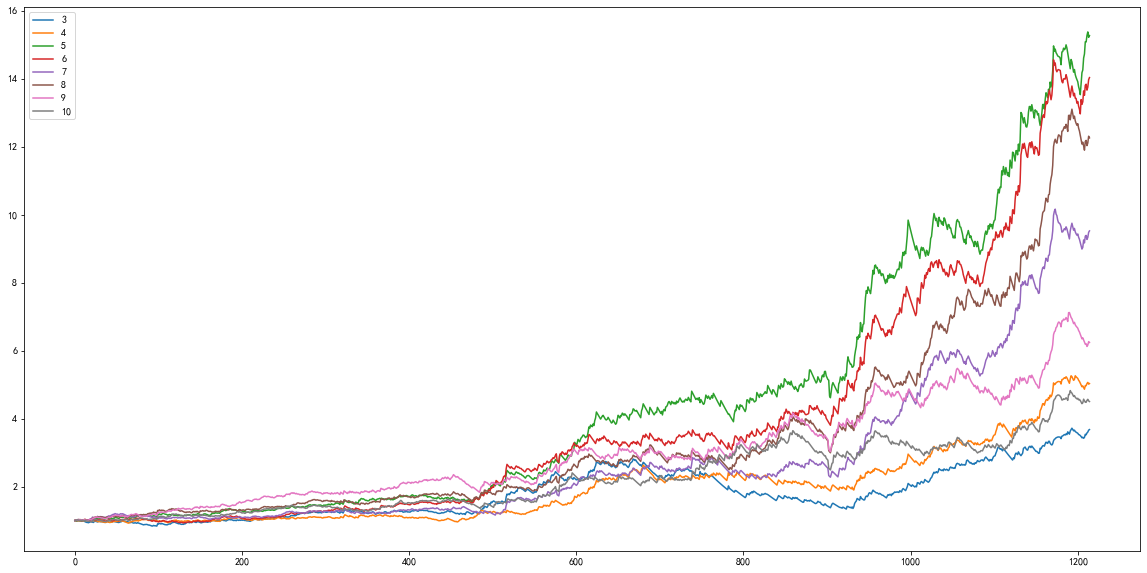

In [77]:
cumu_nv_df.plot(figsize=(20,10))

<AxesSubplot:>

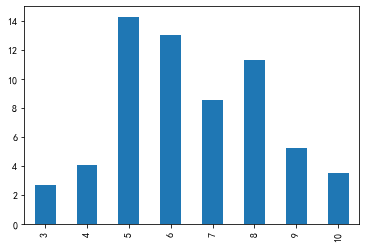

In [82]:
(cumu_nv_df.iloc[-1]-1).plot(kind='bar')

## 六阶模型表现（2005.01.01 - 2013.12.31）

### 定义阶数（N），生成Corpus，计算信号、止损

In [65]:
# 覆盖生成6阶下的初始corpus，用19950101-20041231的历史行情 
my_corpus.load_data(daily_001_1995_2005['close'], 6, is_renew=True)
print('历史样本数', my_corpus.p_df_dict[6]['样本数'].sum())

# 滚动计算signal和sl_price，并不断补充corpus
daily_001 = calc_signal_and_sl_price(daily_001, my_corpus, 6, all_001)
print('历史样本数', my_corpus.p_df_dict[6]['样本数'].sum())

print(daily_001['signal'].value_counts())
daily_001

历史样本数 2420


100%|█████████████████████████████████████████████████████████████████████████████| 4151/4151 [00:10<00:00, 413.68it/s]

历史样本数 6571
 1    2661
-1    1490
Name: signal, dtype: int64


,open,close,high,low,volume,money,date,time,signal,sl_price
0,1260.78,1242.77,1260.78,1238.18,8.161770e+08,4.418452e+09,2005-01-04,23:59:59,1,NaN
1,1241.68,1251.94,1258.58,1235.75,8.678651e+08,4.916589e+09,2005-01-05,23:59:59,-1,1229.2632
2,1252.49,1239.43,1252.73,1234.24,7.922254e+08,4.381370e+09,2005-01-06,23:59:59,-1,1265.0149
3,1239.32,1244.75,1256.31,1235.51,8.940871e+08,5.040042e+09,2005-01-07,23:59:59,1,1251.7132
4,1243.58,1252.40,1252.72,1236.09,7.234683e+08,4.118292e+09,2005-01-10,23:59:59,-1,1231.1442
...,...,...,...,...,...,...,...,...,...,...
4146,3508.24,3524.11,3531.61,3500.14,2.802683e+10,3.580097e+11,2022-01-24,23:59:59,1,3543.3224
4147,3509.28,3433.06,3519.83,3433.06,3.273538e+10,3.837277e+11,2022-01-25,23:59:59,1,3474.1872
4148,3442.69,3455.67,3462.12,3417.76,2.751228e+10,3.383124e+11,2022-01-26,23:59:59,1,3408.2631
4149,3456.10,3394.25,3456.36,3392.02,2.806065e+10,3.465340e+11,2022-01-27,23:59:59,-1,3421.5390


### 策略表现评估 - 不带止损

#### Old Usage

In [24]:
daily_001 = calc_position(daily_001, 
                          shift_period=1, 
                          otime_limit=None, 
                          etime_limit=None, 
                          is_consider_open=True, 
                          is_consider_sl=False, 
                          is_daily_close=False,
                          comm = 0.0002,
                          leverage=None
                         )

res_daily_001, perf_df = statistic_performance(daily_001[daily_001['date']<='2013-12-31'], 
                                               r0=0.03, 
                                               data_period=1440, 
                                               is_consider_sl=False
                                              )
print(perf_df)
visualize_performance(res_daily_001)

                 0
累计收益       430.90%
多仓次数           577
多仓成功次数         323
多仓胜率        55.98%
多仓平均持有期       2.38
空仓次数           576
空仓成功次数         282
空仓胜率        48.96%
空仓平均持有期       1.40
周期胜率        53.28%
最大回撤        43.18%
年化收益/最大回撤     0.47
年化收益        20.39%
年化标准差       27.92%
年化夏普          0.73


#### New Usage

,Overall,2014,2015,2016,2017,2018,2019,2020,2021,2022
累计收益,-58.29%,-5.34%,-39.61%,-29.44%,5.69%,0.28%,-2.62%,-2.64%,-5.98%,-1.01%
多仓次数,546,70,61,68,71,67,69,62,69,5
多仓成功次数,288,34,32,37,41,32,35,38,33,2
多仓胜率,52.75%,48.57%,52.46%,54.41%,57.75%,47.76%,50.72%,61.29%,47.83%,40.00%
多仓平均持有期,2.36,2.19,2.75,2.26,2.17,2.28,2.35,2.63,2.28,2.20
空仓次数,545,70,60,69,72,68,69,63,69,5
空仓成功次数,238,28,18,33,31,36,29,28,31,4
空仓胜率,43.67%,40.00%,30.00%,47.83%,43.06%,52.94%,42.03%,44.44%,44.93%,80.00%
空仓平均持有期,1.25,1.27,1.25,1.29,1.21,1.31,1.17,1.25,1.20,1.40
周期胜率,50.79%,49.80%,50.41%,52.05%,49.59%,51.03%,51.23%,52.26%,49.38%,57.89%


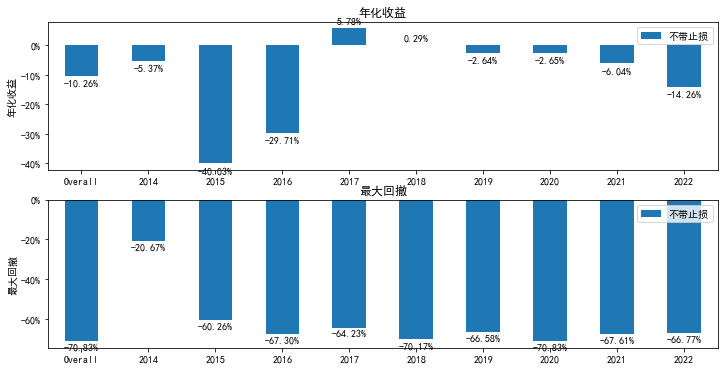

In [72]:
""" 持仓计算 """
daily_001 = calc_position(daily_001, 
                          shift_period=1, 
                          otime_limit=None, 
                          etime_limit=None, 
                          is_consider_open=True, 
                          is_consider_sl=False, 
                          is_daily_close=False,
                          comm = 0.0002,
                          leverage=None
                         )


""" 策略评估 """
evaluator1 = Trade_Evaluator(#daily_001[daily_001['date']<='2013-12-31'], 
                             daily_001[daily_001['date']>'2013-12-31'], 
                             r0=0.03, 
                             data_period=1440, 
                             is_consider_sl=False)
evaluator1.generate_perf_df(with_yearly=True)

""" 统计&可视化 """
# 评估结果DataFrame：perf_df
display(evaluator1.perf_df)
# perf_df中的指标可视化
Visualizor.show_perf_df_indis(perf_df_lst=[(evaluator1.perf_df, '不带止损'),], 
                              indis=['年化收益', '最大回撤'])

In [73]:
""" 统计&可视化 """
# 整体可视化
Visualizor.visualize_evaluated_mkt_data(evaluator1.mkt_data)

### 策略表现评估 - 带止损

#### Old Usage

In [27]:
daily_001 = calc_position(daily_001,
                          shift_period=1, 
                          otime_limit=None, 
                          etime_limit=None, 
                          is_consider_open=True, 
                          is_consider_sl=True, 
                          is_daily_close=False,
                          comm = 0.0002,
                          leverage=None
                         )

res_daily_001, perf_df = statistic_performance(daily_001[daily_001['date']<='2013-12-31'], 
                                               r0=0.03, 
                                               data_period=1440, 
                                               is_consider_sl=True
                                              )
print(perf_df)
visualize_performance(res_daily_001)

                  0
累计收益       2414.40%
多仓次数            853
多仓成功次数          375
多仓胜率         43.96%
多仓平均持有期        1.61
多仓止损次数          471
多仓止损率        55.22%
空仓次数            640
空仓成功次数          276
空仓胜率         43.12%
空仓平均持有期        1.26
空仓止损次数          271
空仓止损率        42.34%
周期胜率         47.23%
最大回撤         23.75%
年化收益/最大回撤      1.82
年化收益         43.12%
年化标准差        21.93%
年化夏普           1.97


#### New Usae

,Overall,2014,2015,2016,2017,2018,2019,2020,2021,2022
累计收益,118.68%,0.18%,7.11%,-1.07%,4.86%,19.52%,13.45%,25.24%,3.74%,0.86%
多仓次数,700,85,107,79,78,87,86,84,84,6
多仓成功次数,325,39,38,40,44,36,42,42,38,2
多仓胜率,46.43%,45.88%,35.51%,50.63%,56.41%,41.38%,48.84%,50.00%,45.24%,33.33%
多仓平均持有期,1.84,1.81,1.57,1.95,1.97,1.76,1.88,1.94,1.87,1.83
多仓止损次数,269,27,76,29,9,33,26,34,32,3
多仓止损率,38.43%,31.76%,71.03%,36.71%,11.54%,37.93%,30.23%,40.48%,38.10%,50.00%
空仓次数,575,74,71,70,75,76,70,64,70,5
空仓成功次数,239,27,18,33,31,38,30,27,31,4
空仓胜率,41.57%,36.49%,25.35%,47.14%,41.33%,50.00%,42.86%,42.19%,44.29%,80.00%


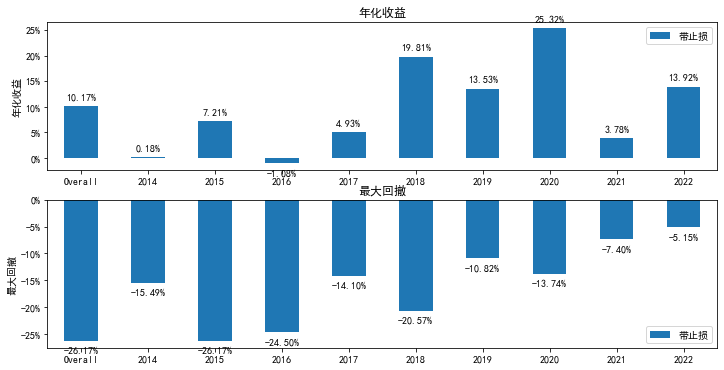

In [74]:
""" 持仓计算 """
daily_001 = calc_position(daily_001, 
                          shift_period=1, 
                          otime_limit=None, 
                          etime_limit=None, 
                          is_consider_open=True, 
                          is_consider_sl=True, 
                          is_daily_close=False,
                          comm = 0.0002,
                          leverage=None
                         )

""" 策略评估 """
evaluator2 = Trade_Evaluator(#daily_001[daily_001['date']<='2013-12-31'], 
                             daily_001[daily_001['date']>'2013-12-31'],
                             r0=0.03, 
                             data_period=1440, 
                             is_consider_sl=True)
evaluator2.generate_perf_df(with_yearly=True)

""" 统计&可视化 """
# 评估结果DataFrame：perf_df
display(evaluator2.perf_df)
# perf_df中的指标可视化
Visualizor.show_perf_df_indis(perf_df_lst=[(evaluator2.perf_df, '带止损'),], 
                              indis=['年化收益', '最大回撤'])

In [75]:
""" 统计&可视化 """
# 整体可视化
Visualizor.visualize_evaluated_mkt_data(evaluator2.mkt_data)

### 策略表现比对 - 止损vs非止损

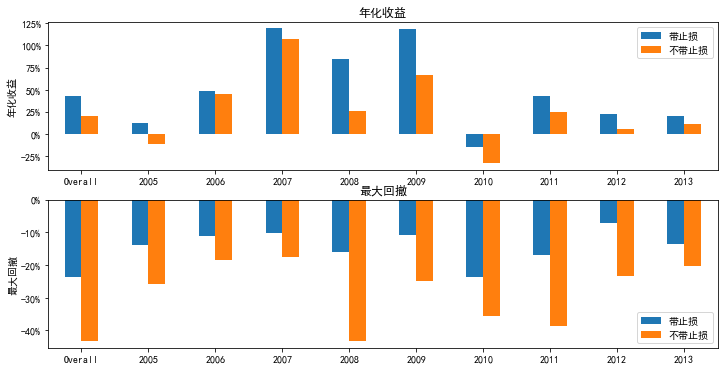

In [71]:
# perf_df中的指标可视化
Visualizor.show_perf_df_indis(perf_df_lst=[ (evaluator2.perf_df, '带止损'),
                                            (evaluator1.perf_df, '不带止损'),
                                          ], 
                              indis=['年化收益', '最大回撤'])